<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-Learning-project" data-toc-modified-id="Deep-Learning-project-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deep Learning project</a></span><ul class="toc-item"><li><span><a href="#Section-0:-Download-and-install-repository" data-toc-modified-id="Section-0:-Download-and-install-repository-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Section 0: Download and install repository</a></span></li><li><span><a href="#Section-2:-Replication-of-results" data-toc-modified-id="Section-2:-Replication-of-results-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Section 2: Replication of results</a></span></li><li><span><a href="#Section-3:-Applications" data-toc-modified-id="Section-3:-Applications-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Section 3: Applications</a></span><ul class="toc-item"><li><span><a href="#Problem-context" data-toc-modified-id="Problem-context-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Problem context</a></span></li><li><span><a href="#Download-database" data-toc-modified-id="Download-database-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Download database</a></span></li><li><span><a href="#Architecture-implementation-in-videos" data-toc-modified-id="Architecture-implementation-in-videos-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Architecture implementation in videos</a></span></li><li><span><a href="#Pose-database-creation" data-toc-modified-id="Pose-database-creation-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Pose-database creation</a></span></li><li><span><a href="#RCNN-architecture-definition" data-toc-modified-id="RCNN-architecture-definition-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>RCNN architecture definition</a></span></li><li><span><a href="#Training-model-definition" data-toc-modified-id="Training-model-definition-1.3.6"><span class="toc-item-num">1.3.6&nbsp;&nbsp;</span>Training model definition</a></span></li><li><span><a href="#User-parameters" data-toc-modified-id="User-parameters-1.3.7"><span class="toc-item-num">1.3.7&nbsp;&nbsp;</span>User parameters</a></span></li></ul></li><li><span><a href="#Anexos:-GitHub-connection" data-toc-modified-id="Anexos:-GitHub-connection-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span><strong><em>Anexos: GitHub connection</em></strong></a></span></li></ul></li></ul></div>

# Deep Learning project
Intro by Tatiana

In [1]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Basis libraries
import os, re, sys, math, time, scipy, argparse, copy
import cv2, matplotlib, json
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ipywidgets import Video

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from collections import OrderedDict
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.filters import gaussian_filter, maximum_filter

Mounted at /content/gdrive


## Section 0: Download and install repository
First, we will download the repository that we copied from the [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation) in order to make some changes for educational purposes. Then, we install libraries and some dependences explained in the original repository.

In [2]:
# Independence install
!sudo apt-get install swig
%cd $colab_path
if not os.path.isdir("RT-multiperson-pose-pytorch"):
  # Repository clone
  !git clone https://github.com/Johansmm/RT-multiperson-pose-pytorch.git
  %cd "RT-multiperson-pose-pytorch"
  %cd lib/pafprocess 
  # Repository compile
  !sh make.sh

# Libraries install
%cd $colab_path"/RT-multiperson-pose-pytorch"
!python -m pip install -r ./requirements.txt
!git submodule init && git submodule update
# Weights download
if not os.path.isfile("./pose_model.pth"):
  !wget https://www.dropbox.com/s/ae071mfm2qoyc8v/pose_model.pth
output.clear()
print("[INFO]: Proyect uploaded successfully")

[INFO]: Proyect uploaded successfully


In [3]:
!python demo/picture_demo.py

Bulding VGG19
Done !
0.5459940652818991


In [4]:
# Framework libraries
%cd $colab_path"/RT-multiperson-pose-pytorch"
sys.path.append('.')
from lib.network.rtpose_vgg import get_model
from lib.network import im_transform
from lib.utils.common import Human, BodyPart, CocoPart, CocoColors, CocoPairsRender, draw_humans
from lib.utils.paf_to_pose import paf_to_pose_cpp
from lib.config import cfg, update_config
from evaluate.coco_eval import get_outputs, handle_paf_and_heat, run_eval

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


## Section 2: Replication of results
In this section we replicated some resutls. First, we need download the data. For this case, we will use the `sh` compiler provided by [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation)

In [5]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
data_download = False # For download COCO dataset
if data_download and not os.path.isdir("data/coco"):
  !mkdir data
  %cd data
  !sh ../lib/datasets/CocoDataDownloader.sh
  %cd $colab_path"/RT-multiperson-pose-pytorch"
  output.clear()
  print("[INFO]: Coco database downloaded successfully")

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


Now, we defined some principal functions and the neuronal network architecture.



In [6]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
class Namespace:
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

def load_rtpose_model():
  args = Namespace(cfg = './experiments/vgg19_368x368_sgd.yaml', weight = 'pose_model.pth', opts = [])
  update_config(cfg, args)
  model = get_model('vgg19')     
  model.load_state_dict(torch.load(args.weight))
  model = torch.nn.DataParallel(model).cuda()
  model.float()
  model.eval()
  return model

def im_forward(image, model):
  with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(image, model, 'rtpose')
  return paf, heatmap, im_scale

def human_forward(image, model):
  paf, heatmap, im_scale = im_forward(image, model)
  humans = paf_to_pose_cpp(heatmap, paf, cfg)
  return draw_humans(image, humans), humans

rtpose_model = load_rtpose_model()

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
Bulding VGG19
Done !


In order to display some results, images will be chosen at random to reproduce the paper's results. A grid will be created with some samples.

[INFO]: Images through RT-multiperson pose 2D:


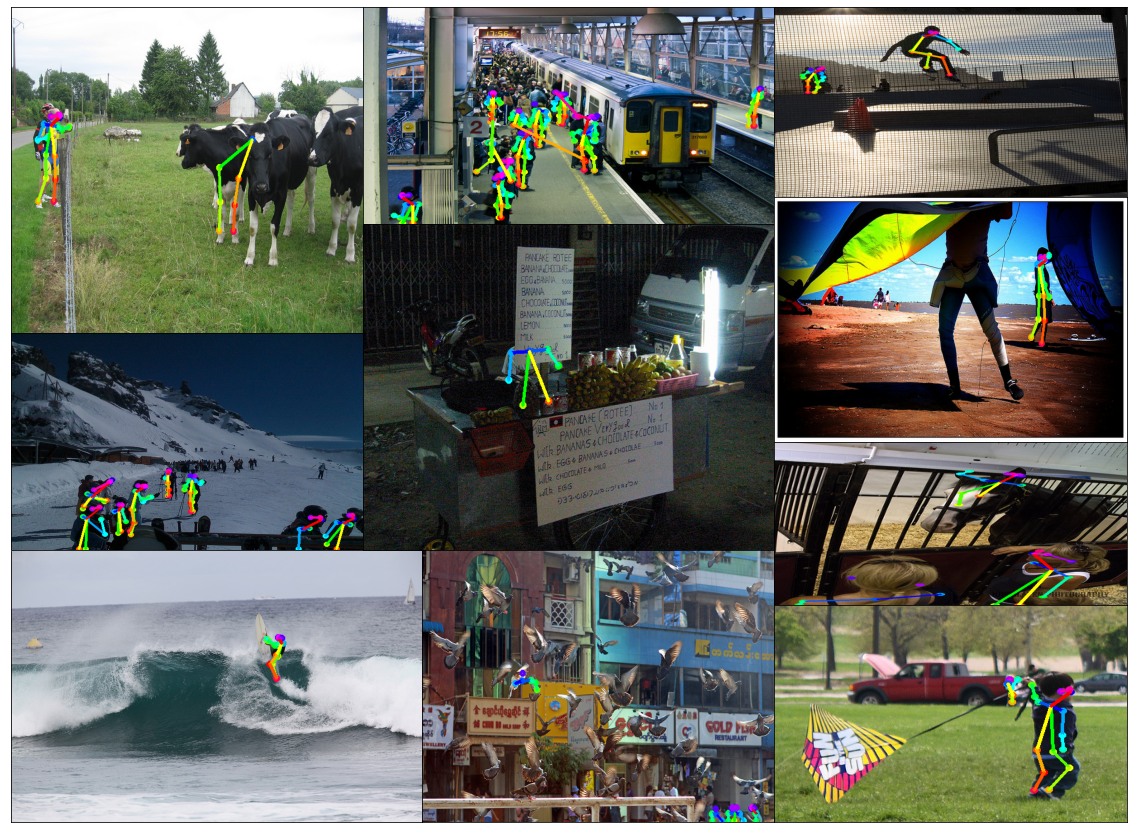

In [7]:
def readFileList(file_directory, ext = 'jpg'):
    files_list = []
    if os.path.isdir(file_directory): # Return files with 'json' extension
        for root_path, _, files_name in os.walk(file_directory):
            files_list += [os.path.join(root_path, element) for element in files_name if element.split(".")[-1].lower() == ext.lower()]
    elif file_directory.split('.')[-1] == ext: files_list = [file_directory] # Return file inside of list
    return files_list

file_list = readFileList("./data/coco/images/test2017")
if len(file_list) > 0:
    print("[INFO]: Images through RT-multiperson pose 2D:")
    fig = plt.figure(figsize=(20, 15), constrained_layout=False)
    gs = fig.add_gridspec(nrows=30, ncols=19, wspace=0.0, hspace=0.0)
    fig_axes = {
        fig.add_subplot(gs[:12, :6]): {"id": "image1_1"}, # First column
        fig.add_subplot(gs[12:20, :6]): {"id": "image2_1"},
        fig.add_subplot(gs[20:, :7]): {"id": "image3_1"},
        fig.add_subplot(gs[:8, 6:13]): {"id": "image1_2"}, # Second column
        fig.add_subplot(gs[8:20, 6:13]): {"id": "image2_2"},
        fig.add_subplot(gs[20:, 7:13]): {"id": "image3_2"},
        fig.add_subplot(gs[:7, 13:]): {"id": "image7"}, # Third column
        fig.add_subplot(gs[7:16, 13:]): {"id": "image8"},
        fig.add_subplot(gs[16:22, 13:]): {"id": "image9"},
        fig.add_subplot(gs[22:, 13:]): {"id": "image10"},
    }

    for ax, prop in fig_axes.items():
        human_det = []
        while len(human_det) == 0:
            image = cv2.imread(np.random.choice(file_list))
            image_rt, human_det = human_forward(image, rtpose_model)
        ax.imshow(cv2.cvtColor(image_rt, cv2.COLOR_BGR2RGB), aspect = "auto")
        ax.set_xticklabels([]); ax.set_yticklabels([])
        ax.set_xticks([]); ax.set_yticks([]); ax.axis("on")
    fig.show()
else:
    print("[INFO]: Not image found. Please check image folder")

In [8]:
isrun = False
try:
    if isrun:
        run_eval(image_dir= './data/coco/images/val2017', 
          anno_file = './data/coco/annotations/annotations/person_keypoints_val2017.json', 
          vis_dir = './data/coco/images/vis_val2017', model=model, preprocess='vgg')
except:
    pass

The summary of the evaluation statistics are presented below. For the validation set, we can see that the model is recognizing about 13% of the cases correctly, of which we can be sure that about 20% are being well detected.

<table>
<tbody>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50:0.95</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.091</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.223</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.75</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.057</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50:0.95</th> <th>area = medium</th> <th>maxDets = 20</th> <th>0.131</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50:0.95</th> <th>area = large</th> <th>maxDets = 20</th> <th>0.091</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50:0.95</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.188</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.350</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.75</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.167</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50:0.95</th> <th>area = medium</th> <th>maxDets = 20</th> <th>0.140</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50:0.95</th> <th>area = large</th> <th>maxDets = 20</th> <th>0.255</th>
  </tr>
</tbody>
</table>

## Section 3: Applications
Some applications in the field of deep learning have been developed in recent years with themes relating to the detection of the position of people in different scenes. Some of these include the classification of postures, detection of people in position, robots assisted living, character animation, video games industry, medical applications such as postural corrections, and anothers [interesting projects](https://medium.com/beyondminds/an-overview-of-human-pose-estimation-with-deep-learning-d49eb656739b). Below are some articles of interest:

1.   [Multi-Person Pose Estimation for Pose Tracking with Enhanced Cascaded Pyramid Network](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11130/Yu_Multi-Person_Pose_Estimation_for_Pose_Tracking_with_Enhanced_Cascaded_Pyramid_ECCVW_2018_paper.pdf)
2.   [Single-Stage Multi-Person Pose Machines](https://arxiv.org/pdf/1908.09220.pdf)
3.   [Rehabilitation Posture Correction Using Deep Neural
Network](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7881743)
4.   [Pose Trainer: Correcting Exercise Posture using Pose Estimation](https://arxiv.org/abs/2006.11718)



In this notebook, we will attack in a particular aplication: The detection of multiple person poses in videos and their prediction in later frames. For this, we will use the [`tv_human_interactions`](https://www.robots.ox.ac.uk/~vgg/data/tv_human_interactions/) database.

### Problem context

We must understand that for every image in the video, we have that the network predicts an affinity map and a body part map, with sizes  $(46,83,38)$ and $(46,83,19)$, respectively. To predict the pose in future frames of a video we will use this information as an RCNN target, coupling each detection in a single tensor. The idea will be to be able to predict these two maps of a given frame a map of the current state, coupled into a single map set of $(46,83,57)$ size for a single image.

### Download database

As mentioned above, the database will be downloaded from [`tv_human_interactions`](https://www.robots.ox.ac.uk/~vgg/data/tv_human_interactions/). A state flag will allow you to switch between downloading and not downloading the database.

In [9]:
download_tv_human = False
if download_tv_human and not os.path.isdir("./data/tv_human_interactions_videos"):
    if not os.path.isdir("./data"): os.mkdir("./data")
    !wget -P "./data" "https://www.robots.ox.ac.uk/~vgg/data/tv_human_interactions/data/tv_human_interactions_videos.tar.gz"
    !tar -xzvf "./data/tv_human_interactions_videos.tar.gz" -C "./data"
    os.remove("./data/tv_human_interactions_videos.tar.gz")
    output.clear()
    print("[INFO] TV Human Interactions database download succesfully!.")

### Architecture implementation in videos
Let's start with the implementation of the architecture in a test video. We will make the frame to frame reading, showing the result of the estimation.

In [10]:
''' Extract properties from video '''
def video_prop_read(video_path, force_mp4 = True):
    video = cv2.VideoCapture(video_path) # Read video
    w,h = int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_fps = video.get(cv2.CAP_PROP_FPS)
    codec = [chr((int(video.get(cv2.CAP_PROP_FOURCC)) >> 8 * i) & 0xFF) for i in range(4)]
    video_size = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video.release()
    if "mp4" in os.path.splitext(video_path)[-1].lower() or force_mp4: codec = ['m', 'p', '4', 'v']
    if video_size <= 0: video_size = np.inf
    if video_fps <= 0 or video_fps == np.inf: video_fps = 25 # Default value
    return w, h, video_fps, codec, video_size

''' Show embed video'''
def show_video(video_path):
    filename, ext = os.path.splitext(video_path)
    if os.path.isfile(video_path):
        if "mp4" not in ext.lower():
            filename += ".mp4"
            !sudo ffmpeg -t 5 -i "$video_path" "$filename" # Convert any ext to mp4
            output.clear()
            video_path = filename
        video = Video.from_file(video_path)
    else:
        print("[ERROR] Video file not found. Please check path.")
        video = None
    return video

''' Draw humans in video '''
def video_forward(video_in, fps = None, video_out_path = None, force_mp4 = True,
                  total_frames = None, skip_frames = None, resize = None, 
                  background = True, print_im = False):
    # Read video properties
    video_w, video_h, video_fps, video_codec, video_size = video_prop_read(video_in, force_mp4)
    video = cv2.VideoCapture(video_in)

    # Video object to save and video_in read
    if fps is not None and fps < video_fps: video_fps = fps
    if video_out_path is not None:
        video_out_path, ext = os.path.splitext(video_out_path)
        if force_mp4: video_out_path += ".mp4"
        elif len(ext) == 0: video_out_path += os.path.splitext(video_in)[-1]
        else: video_out_path += ext
        if resize is not None: video_w, video_h = resize
        video_out = cv2.VideoWriter(video_out_path, cv2.VideoWriter_fourcc(*video_codec), 
                                    video_fps, (video_w, video_h))
        print("[INFO]: Video will be saved in", video_out_path)

    fcount = 0; tic = time.time(); total_paf = []; total_heat = []; sizes = []; rcount = 0
    while video.isOpened():
        ret, frame = video.read(); fcount += 1
        if fps is not None and fcount % (fps//video_fps) != 0: continue # Skip frames
        rcount += 1
        if skip_frames is not None and rcount <= skip_frames : continue # Skip frames
        if (cv2.waitKey(1) & 0xFF == ord('q')) or not ret: break # End of video

        # Detection process
        paf, heatmap, im_scale = im_forward(frame, rtpose_model) # CNN maps
        paf = np.where(np.abs(paf) < 0.3, 0.0, paf)
        heatmap = np.where(heatmap < 0.5, 0.0, heatmap)
        total_paf += [paf]; total_heat += [heatmap]; sizes += [im_scale] # Concat detections

        # Save pose-detection in video_out
        if video_out_path is not None or print_im:
            humans = paf_to_pose_cpp(heatmap, paf, cfg)
            if not background: frame = np.zeros(frame.shape, dtype = "uint8")
            frame_out = draw_humans(frame, humans)
            if resize is not None: frame_out = cv2.resize(frame_out, resize)
            if video_out_path is not None: video_out.write(frame_out)
        
        # if isprogrammer: cv2.imshow("output.mp4", frame)
        if fcount % 30 == 0:
            print("[INFO]: {} of {} frames processed.".format(fcount, video_size))
            if print_im: 
                plt.imshow(cv2.cvtColor(frame_out, cv2.COLOR_BGR2RGB))
                plt.axis("off"); plt.show()
        
        if total_frames is not None and rcount >= total_frames: break # End
        
    video.release()
    if video_out_path is not None: 
        video_out.release()
        if "mp4" in os.path.splitext(video_out_path)[-1]:
            video_out_path_compress = video_out_path.replace(".mp4","_out.mp4")
            !sudo ffmpeg -t 5 -i "$video_out_path" "$video_out_path_compress" # Compress
            !mv "$video_out_path_compress" "$video_out_path"
            !rm "$video_out_path_compress"
            output.clear()
        print("[INFO]: Video saved successfully")
    print("[INFO]: Total time spend in procedure:", time.time() - tic, "s")
    if len(total_paf) == 0: return None, None, None
    else: return np.stack(total_paf, axis = 0), np.stack(total_heat, axis = 0), sizes

In [11]:
video_path_proof = "./data/Videos_Deep_MiosHAHA/Entrenamiento/Original1_Train.mp4"
demo_pred = video_forward(video_path_proof, video_out_path = "./demo/video_demo", 
                          resize = (720,480), fps = 150, background = True, print_im = True)
print(demo_pred[0].shape, demo_pred[1].shape)

[INFO]: Video saved successfully
[INFO]: Total time spend in procedure: 15.84722113609314 s
(47, 46, 82, 38) (47, 46, 82, 19)


In [12]:
show_video("./demo/video_demo.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07\xde7mdat\x00\x…

### Pose-database creation
After we have tested the network in a simple video, we will split the video list files into test, train and validation sets.

In addition, we will perform a mini-batch training, where each batche will be represented by each video. Therefore, we will define a function that will allow us to process each video and organize it in tensors, so that it organizes the information for the input/output training process. As the input is the composition of the prediction in $N$ previous states to predict the $N+1$ state (output), the dimenssions of the input tensor will be of $(x,N,46,83,57)$ and $(x,46,83,57)$ for the output, with $x$ the total of images in the video. If we desired $N=1$, $(x,46,83,57)$ will be the dimension of the entry tensor.

In [13]:
# Train, test and valid video lists creation
random_state = 42
video_list = readFileList("./data/tv_human_interactions_videos/", ext = 'avi')
videoloaders = {x:y for x,y in zip(["train","test"], train_test_split(video_list, test_size = 0.3, random_state = random_state))}
videoloaders.update({x:y for x,y in zip(["valid","test"], train_test_split(videoloaders["test"], test_size = 0.5, random_state = random_state))})
video_set_sizes = {x: len(videoloaders[x]) for x in ['train', 'valid', 'test']}
print(video_set_sizes)

{'train': 210, 'valid': 45, 'test': 45}


In [14]:
random_state = 42
np.random.seed(random_state)
videoloaders = {x:readFileList("./data/Videos_Deep_MiosHAHA/" + y, ext = "mp4") for x,y in zip(["train","valid","test"],["Entrenamiento","Validacion","Test"])}
video_set_sizes = {x: len(videoloaders[x]) for x in ['train', 'valid', 'test']}
print(video_set_sizes)

{'train': 8, 'valid': 8, 'test': 8}


In [15]:
# Load (predict) video and split it in in/out tensor
def video_batch(video_path, n_past_step = 12, n_fut_step = 12, 
                batch_size = None, skip_batch = None, **kwargs): # (b,t,c,h,w)
    total_frames = batch_size; skip_frames = skip_batch
    if skip_frames is not None: skip_frames *= n_past_step + n_fut_step
    if batch_size is not None: 
        total_frames *= n_past_step + n_fut_step
        if skip_frames is not None: total_frames += skip_frames
        
    tpaf, theat, _ = video_forward(video_path, # Video forward in RT-model (frames,h,w,c)
            total_frames = total_frames, skip_frames = skip_frames, **kwargs)
    if tpaf is None or theat is None: return None, None
    paf_batch, heat_batch = [], []
    for t in range(len(tpaf)//(n_past_step + n_fut_step)): # Batches of (B,n_steps,H,W,C)
        paf_batch.append(tpaf[t*(n_past_step + n_fut_step):(t+1)*(n_past_step + n_fut_step)])
        heat_batch.append(theat[t*(n_past_step + n_fut_step):(t+1)*(n_past_step + n_fut_step)])
    if len(heat_batch) == 0 or len(paf_batch) == 0: return None, None
    paf_batch = torch.as_tensor(np.stack(paf_batch, axis = 0), dtype = torch.float32)
    heat_batch = torch.as_tensor(np.stack(heat_batch, axis = 0), dtype = torch.float32)
    return paf_batch.permute(0,1,4,2,3), heat_batch.permute(0,1,4,2,3) # Tensors organize to (B,past+future,C,H,W)

### RCNN architecture definition

In [34]:
''' Defined a single convLSTM module '''
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int # Number of channels of input tensor.
        hidden_dim: int # Number of channels of hidden state.
        kernel_size: (int, int) # Size of the convolutional kernel.
        bias: bool # Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels = self.input_dim + self.hidden_dim,
                              out_channels = 4 * self.hidden_dim,
                              kernel_size = self.kernel_size,
                              padding = self.padding, bias = self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        # concatenate along channel axis
        combined = torch.cat([input_tensor, h_cur], dim = 1) # (B,c,h,w)

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim = 1)
        i = torch.sigmoid(cc_i) # (B, hidden, h, w)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [71]:
class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, nf, in_chan):
        super(EncoderDecoderConvLSTM, self).__init__()

        """ ARCHITECTURE 

        # Encoder (ConvLSTM)
        # Encoder Vector (final hidden state of encoder)
        # Decoder (ConvLSTM) - takes Encoder Vector as input
        # Decoder (3D CNN) - produces regression predictions for our model

        """
        self.encoder_1_convlstm = ConvLSTMCell(input_dim=in_chan, hidden_dim=nf, kernel_size=(3, 3), bias=True)
        self.encoder_2_convlstm = ConvLSTMCell(input_dim=nf, hidden_dim=2*nf, kernel_size=(3, 3), bias=True)
        self.decoder_1_convlstm = ConvLSTMCell(input_dim=2*nf, hidden_dim=2*nf, kernel_size=(3, 3), bias=True)
        self.decoder_2_convlstm = ConvLSTMCell(input_dim=2*nf, hidden_dim=nf, kernel_size=(3, 3), bias=True)
        self.decoder_CNN = nn.Conv3d(in_channels=nf, out_channels=in_chan, kernel_size=(1, 3, 3), padding=(0, 1, 1))

        # Others
        self.maxpool = nn.MaxPool2d(2, return_indices = True)
        self.unmaxpool = nn.MaxUnpool2d(2)

    def autoencoder(self, x, seq_len, future_step, hte_1, hte_2, htd_1, htd_2, cte_1, cte_2, ctd_1, ctd_2):
        # encoder
        print(x.shape, hte_1.shape, cte_1.shape)
        for t in range(seq_len):
            hte_1, cte_1 = self.encoder_1_convlstm(input_tensor = x[:, t, :, :, :], cur_state = [hte_1, cte_1])
            hte_1_max, ind_htd_2 = self.maxpool(hte_1)

            hte_2, cte_2 = self.encoder_2_convlstm(input_tensor = hte_1_max, cur_state = [hte_2, cte_2])
        
        encoder_vector, ind_htd_1 = self.maxpool(hte_2) # (B, Hidden, H, W)

        # decoder
        outputs = []
        new_dim = [htd_2.shape[0], htd_2.shape[1], htd_2.shape[2], htd_2.shape[3]]
        for t in range(future_step):
            htd_1, ctd_1 = self.decoder_1_convlstm(input_tensor = encoder_vector, cur_state = [htd_1, ctd_1])
            new_dim[1] = htd_1.shape[1]
            htd_1_max = self.unmaxpool(htd_1, ind_htd_1, output_size = torch.Size(new_dim))
            
            htd_2, ctd_2 = self.decoder_2_convlstm(input_tensor = htd_1_max, cur_state = [htd_2, ctd_2])
            encoder_vector = self.unmaxpool(htd_2, ind_htd_2) # (B,hidden,H,W)

            outputs += [encoder_vector] # predictions

        # Prediction handled
        outputs = torch.stack(outputs, dim = 1) # (B,future_step,hidden,H,W)
        outputs = outputs.permute(0, 2, 1, 3, 4) # (B,hidden,future_step,H,W)
        outputs = self.decoder_CNN(outputs) # (B,C,future_step,H,W)
        outputs = torch.nn.Tanh()(outputs)
        outputs = outputs.permute(0, 2, 1, 3, 4) # (B,future_step,C,H,W)

        return outputs
    
    def forward(self, x, n_step_fut, hidden_state = None):

        """
        Parameters
        ----------
        input_tensor:
            5-D Tensor of shape (b, t, c, h, w) # batch, time, channel, height, width
        """

        # find size of different input dimensions
        b, seq_len, _, h, w = x.size()

        # initialize hidden states
        if hidden_state is None:
            hidden_state = {}
            hidden_state["hte_1"], hidden_state["cte_1"] = self.encoder_1_convlstm.init_hidden(batch_size = b, image_size=(h, w))
            hidden_state["hte_2"], hidden_state["cte_2"] = self.encoder_2_convlstm.init_hidden(batch_size = b, image_size=(h//2, w//2))
            
            hidden_state["htd_1"], hidden_state["ctd_1"] = self.decoder_1_convlstm.init_hidden(batch_size = b, image_size=(h//4, w//4))
            hidden_state["htd_2"], hidden_state["ctd_2"] = self.decoder_2_convlstm.init_hidden(batch_size = b, image_size=(h//2, w//2))

        # autoencoder forward
        outputs = self.autoencoder(x, seq_len, n_step_fut, **hidden_state)

        return outputs

In [72]:
class RTposeEDConvLSTM(nn.Module):
    def __init__(self, nf, in_chan):
        super(RTposeEDConvLSTM, self).__init__()
        """ ARCHITECTURE 

        # Autoecoder (heatmap)
        # Autoencoder (paf)

        """

        self.paf_autoencoder = EncoderDecoderConvLSTM(nf, in_chan[0])
        self.heat_autoencoder = EncoderDecoderConvLSTM(nf, in_chan[1])

    def forward(self, x, n_step_fut, hidden_state = None):

        """
        Parameters
        ----------
        input_tensor:
            List with two 5-D Tensor of shape (b, t, c, h, w) # batch, time, channel, height, width
        """

        paf_output = self.paf_autoencoder(x[0], n_step_fut, hidden_state)
        heat_output = self.heat_autoencoder(x[1], n_step_fut, hidden_state)

        return paf_output, heat_output

### Training model definition



In [73]:
def train_step(model, criterion, optimizer = None, phase = 'valid', **kwargs):
    if phase == 'train': model.train()  # Set model to training mode
    else: model.eval() # Set model to evaluate mode

    skip_batch, losses, batch_count = 0, 0.0, 0
    while True:
        paf_batch, heat_batch = video_batch(skip_batch = skip_batch, **kwargs) # Batch of (B,frames,C,H,W)
        if paf_batch is None or heat_batch is None: break # Invalid video read.
        batch_count += 1

        # Batch I/O split
        x_paf = paf_batch[:, :kwargs["n_past_step"]].cuda() # Batch of (B,n_steps,C,H,W)
        y_paf = paf_batch[:, kwargs["n_past_step"]:].cuda() # Batch of (B,future_step,C,H,W)
        x_heat = heat_batch[:, :kwargs["n_past_step"]].cuda() # Batch of (B,n_steps,C,H,W)
        y_heat = heat_batch[:, kwargs["n_past_step"]:].cuda() # Batch of (B,future_step,C,H,W)

        # forward
        with torch.set_grad_enabled(phase == 'train'): # track history if only in train
            y_hat1, y_hat2 = model([x_paf, x_heat], n_step_fut = kwargs["n_fut_step"])
            loss = criterion(y_hat1, y_paf) + criterion(y_hat2, y_heat)
            if phase == 'train': # backward + optimize only if in training phase
                optimizer.zero_grad(); loss.backward(); optimizer.step()

        losses += loss.item() * x_paf.size(0) # Total images
        
        if kwargs["batch_size"] is not None: skip_batch += kwargs["batch_size"]
        else: break # Invalid video read.
    if batch_count == 0: return None
    else: return losses/batch_count

def load_stats(model, stat_name, model_name):
    if stat_name is not None and os.path.isfile(stat_name):
        with open(stat_name, "r") as f: stats = json.load(f) # Recovery stats
        if model_name is not None: stats["model_name"] = model_name
    else:
        stats = {"losses": {"train": [], "valid": []}, "cur_epoch":0, # Variable to save all
                "best_epoch": 0, "best_loss": np.inf, "time_process": 0,
                 "model_name": model_name}
    if os.path.isfile(stats["model_name"]):
        model.load_state_dict(torch.load(stats["model_name"]))
        model.cuda()
    print(model)
    return model, stats

def training(EDconvLST_model, criterion, optimizer, scheduler = None, num_epochs = 25, 
             model_name = None, early_max = None, n_steps_past = 10, future_step = 10, 
             stat_name = None, batch_size = None):
    
    since = time.time(); count_max = 0; tic = since

    # Model initialization
    EDconvLST_model, stats = load_stats(EDconvLST_model, stat_name, model_name)
    t0 = stats["time_process"]
    if stats["cur_epoch"] >= num_epochs: 
        print("[INFO] Model already was training. Return (if exist) the train model")
        if stats["model_name"] is None: EDconvLST_model = None
        return EDconvLST_model, stats
    
    # Train process
    for epoch in range(1, num_epochs+1):
        # torch.cuda.empty_cache()
        if epoch <= stats["cur_epoch"]: continue # Skip epochs
        isprint = num_epochs <= 1000 or (epoch-1) % (num_epochs // 10) == 0 or epoch == num_epochs

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            # Iterate over data.
            running_loss = 0.0
            np.random.shuffle(videoloaders[phase])
            for i,video_path in enumerate(videoloaders[phase]): # Start for
                if isprint: print("[INFO] {}: Reading video {}/{}".format(phase, i, video_set_sizes[phase]))
                
                loss = train_step(EDconvLST_model, criterion, optimizer = optimizer, phase = phase, 
                                  video_path = video_path, n_past_step = n_steps_past, n_fut_step = future_step, 
                                  batch_size = batch_size, resize = (720,480), fps = 150)
                
                if isprint: 
                    output.clear()
                    print('\nEpoch {}/{}\n{}'.format(epoch, num_epochs, '-'*15))
                    if len(stats["losses"]["train"]) > 0: train_loss = stats["losses"]["train"][-1]
                    else: train_loss = np.inf
                    if loss is not None:
                        print('[INFO] {}: Current loss = {:.6f}, last train loss = {:.6f}, best valid loss = {:.6f}'.\
                          format(phase, loss, train_loss, stats["best_loss"]))
                    else:
                        print('[INFO] {}: Last train loss = {:.6f}, best valid loss = {:.6f}'.\
                          format(phase, train_loss, stats["best_loss"]))
            
                if loss is not None: running_loss += loss
            if isprint: output.clear() # Errase print info
            if phase == 'train' and scheduler is not None: scheduler.step()
            stats["losses"][phase].append(running_loss/video_set_sizes[phase])
        
        time_elapsed = time.time() - tic
        if isprint: # Print somethings for some epoch
            print('train Loss: {:.6f} \tvalid Loss: {:.6f}. Spend time:{:.0f}m {:.0f}s'\
                .format(stats["losses"]["train"][-1], stats["losses"]["valid"][-1], time_elapsed // 60, time_elapsed % 60))
            tic = time.time() # For next iteration

        # deep save model
        if stats["losses"]["valid"][-1] < stats["best_loss"]:
            if isprint: 
                print('Valid loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(stats["best_loss"], stats["losses"]["valid"][-1]))
            stats["best_epoch"] = epoch
            stats["best_loss"] = stats["losses"]["valid"][-1]
            best_model_wts = copy.deepcopy(EDconvLST_model.state_dict())
            if model_name is not None: torch.save(best_model_wts, model_name)
            count_max = 0
        else: 
            count_max += 1 
            if early_max is not None and count_max >= early_max: break # Early finish training

        stats["time_process"] = time.time() - since + t0
        stats["cur_epoch"] = epoch
        if stat_name is not None: 
            with open(stat_name, "w") as f: json.dump(stats, f)

    print('\n{}\nTraining complete ({}/{} epochs) in {:.0f}m {:.0f}s'\
          .format('-'*25, epoch, num_epochs, stats["time_process"] // 60, stats["time_process"] % 60))
    print('Best metric (loss): {:4f}'.format(stats["best_loss"]))

    # load best model weights
    EDconvLST_model.load_state_dict(best_model_wts)
    EDconvLST_model.cuda()
    return EDconvLST_model, stats

### User parameters

In [74]:
# User parameters
n_steps_past = 10
n_steps_fut = 1
num_epochs = 100

In [75]:
EDCLSTM_model = RTposeEDConvLSTM(nf = 32, in_chan = [38,19])
EDCLSTM_model.cuda()
criterion = nn.MSELoss(reduction = "sum").cuda()
optimizer = optim.Adam(EDCLSTM_model.parameters(), lr = 1e-2, betas=(0.9, 0.98))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

In [ ]:
model_file = "EDCLSTM_exp_max.pt"
statistics_file = "EDCLSTM_exp_max.json"
EDCLSTM_model, EDCLSTM_stats = training(EDCLSTM_model, criterion, optimizer, batch_size = None,
             num_epochs = num_epochs, early_max = None, n_steps_past = n_steps_past, scheduler = scheduler,
             future_step = n_steps_fut, stat_name = statistics_file, model_name = model_file)
# EDCLSTM_model, EDCLSTM_stats = load_stats(EDCLSTM_model, statistics_file, model_file)


Epoch 1/100
---------------
[INFO] train: Current loss = 52465.109375, last train loss = inf, best valid loss = inf
[INFO] train: Reading video 2/8
[INFO]: 30 of 900 frames processed.
[INFO]: 60 of 900 frames processed.
[INFO]: 90 of 900 frames processed.
[INFO]: 120 of 900 frames processed.
[INFO]: 150 of 900 frames processed.
[INFO]: 180 of 900 frames processed.
[INFO]: 210 of 900 frames processed.
[INFO]: 240 of 900 frames processed.
[INFO]: 270 of 900 frames processed.
[INFO]: 300 of 900 frames processed.
[INFO]: 330 of 900 frames processed.
[INFO]: 360 of 900 frames processed.
[INFO]: 390 of 900 frames processed.
[INFO]: 420 of 900 frames processed.
[INFO]: 450 of 900 frames processed.
[INFO]: 480 of 900 frames processed.
[INFO]: 510 of 900 frames processed.
[INFO]: 540 of 900 frames processed.
[INFO]: 570 of 900 frames processed.
[INFO]: 600 of 900 frames processed.
[INFO]: 630 of 900 frames processed.
[INFO]: 660 of 900 frames processed.
[INFO]: 690 of 900 frames processed.
[IN

In [ ]:
def loss_plot(losses):
    for phase in ["train", "valid"]:
        plt.plot(range(1, len(losses[phase]) + 1), losses[phase], label = phase + " losses")
    plt.legend(prop = {'size': 10})
    plt.title('loss function', size = 10)
    plt.xlabel('epoch', size = 10); plt.ylabel('loss value', size = 10)

loss_plot(EDCLSTM_stats["losses"])

In [ ]:
def test_metrics(model, video_list, criterion, np, nf): # Metricas
    running_loss = 0.0
    for video_path in video_list: # Start for
        loss = train_step(model, criterion, video_path = video_path, 
                          n_past_step = np, n_fut_step = nf, 
                          batch_size = None, resize = (720,480), fps = 150)
        if loss is not None: running_loss += loss
    running_loss /= len(video_list)
    output.clear()
    print("[INFO] Loss in dataset:", running_loss)

test_metrics(EDCLSTM_model, videoloaders["test"], criterion, np = n_steps_past, nf = n_steps_fut)

In [ ]:
''' Draw humans in video  with detection'''
def video_prediction(model, video_in, step_past, fps = None, video_out_path = None, force_mp4 = True,
                  total_frames = None, skip_frames = None, resize = None, 
                  background = True, print_im = False):
    # Read video properties
    video_w, video_h, video_fps, video_codec, video_size = video_prop_read(video_in, force_mp4)
    video = cv2.VideoCapture(video_in)

    # Video object to save and video_in read
    if fps is not None and fps < video_fps: video_fps = fps
    if video_out_path is not None:
        video_out_path, ext = os.path.splitext(video_out_path)
        if force_mp4: video_out_path += ".mp4"
        elif len(ext) == 0: video_out_path += os.path.splitext(video_in)[-1]
        else: video_out_path += ext
        if resize is not None: video_w, video_h = resize
        video_out = cv2.VideoWriter(video_out_path, cv2.VideoWriter_fourcc(*video_codec), 
                                    video_fps, (video_w, video_h))
        print("[INFO]: Video will be saved in", video_out_path)

    fcount = 0; tic = time.time(); total_paf = []; total_heat = []; rcount = 0
    model.eval()
    while video.isOpened():
        ret, frame = video.read(); fcount += 1
        if fps is not None and fcount % (fps//video_fps) != 0: continue # Skip frames
        rcount += 1
        if skip_frames is not None and rcount <= skip_frames : continue # Skip frames
        if (cv2.waitKey(1) & 0xFF == ord('q')) or not ret: break # End of video

        # Detection process
        if len(total_paf) < step_past:
            paf, heatmap, _ = im_forward(frame, rtpose_model) # CNN maps
            total_paf += [paf]; total_heat += [heatmap]; # Concat detections
            # plt.hist(paf.flatten(), bins = 12); plt.hist(heatmap.flatten(), bins = 12); 
            # plt.show()
        else:
            paf_i, heatmap_i, _ = im_forward(frame, rtpose_model) # CNN maps
            with torch.set_grad_enabled(False):
                x_paf = torch.as_tensor(np.stack(total_paf, axis = 0)[None], dtype = torch.float32).cuda().permute(0,1,4,2,3) # to (B,sp,C,H,W)
                x_heat = torch.as_tensor(np.stack(total_heat, axis = 0)[None], dtype = torch.float32).cuda().permute(0,1,4,2,3) # to (B,sp,C,H,W)
                paf, heatmap = model([x_paf, x_heat], n_step_fut = 1) # Only one future prediction
                paf = paf.squeeze().permute(1,2,0).cpu().detach().numpy() # Size of (H,W,C)
                heatmap = heatmap.squeeze().permute(1,2,0).cpu().detach().numpy() # Size of (H,W,C)
            total_paf += [paf]; total_heat += [heatmap]; # Concat detections
            # total_paf = total_paf[-step_past:]; total_heat = total_heat[-step_past:]
            mse = (np.square(paf - paf)).sum(axis=None)
            print("[INFO]: MSE = ", mse)
        
        # Save pose-detection in video_out
        if video_out_path is not None or print_im:
            humans = paf_to_pose_cpp(heatmap, paf, cfg)
            if not background: frame = np.zeros(frame.shape, dtype = "uint8")
            frame_out = draw_humans(frame, humans)
            if resize is not None: frame_out = cv2.resize(frame_out, resize)
            if video_out_path is not None: video_out.write(frame_out)
        
        # if isprogrammer: cv2.imshow("output.mp4", frame)
        if fcount % 1 == 0:
            print("[INFO]: {} of {} frames processed.".format(fcount, video_size))
            if print_im: 
                plt.imshow(cv2.cvtColor(frame_out, cv2.COLOR_BGR2RGB))
                plt.axis("off"); plt.show()
        
        if total_frames is not None and rcount >= total_frames: break # End
        
    video.release()
    if video_out_path is not None: 
        video_out.release()
        if "mp4" in os.path.splitext(video_out_path)[-1]:
            video_out_path_compress = video_out_path.replace(".mp4","_out.mp4")
            !sudo ffmpeg -t 5 -i "$video_out_path" "$video_out_path_compress" # Compress
            !mv "$video_out_path_compress" "$video_out_path"
            !rm "$video_out_path_compress"
            output.clear()
        print("[INFO]: Video saved successfully")
    print("[INFO]: Total time spend in procedure:", time.time() - tic, "s")
    if len(total_paf) == 0: return None, None
    else: return np.stack(total_paf, axis = 0), np.stack(total_heat, axis = 0)

In [ ]:
video_path_proof = "./data/Videos_Deep_MiosHAHA/Entrenamiento/Original1_Train.mp4"
demo_pred2 = video_prediction(EDCLSTM_model, video_path_proof, step_past = n_steps_past, 
                              resize = (720,480), fps = 150, background = True, skip_frames = 6,
                              print_im = True)
print(demo_pred2[0].shape, demo_pred2[1].shape)

## ***Anexos: GitHub connection***
Here, some functions to upload the github respository

In [ ]:
''' Function definitions'''
# Git pull
def git_pull(repo_pwd, show_current_branch = False, make_commit = False): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        # !git config --list
        if show_current_branch: 
            !git branch 
        if make_commit:
            if "user_git" not in globals(): user_git = input("User github?: ")
            if "email_git" not in globals(): email_git = input("Email github?: ") 
            !git config --global user.email "$email_git"
            !git config --global user.name "$user_git"
            !git commit -am "Updating in colab"
        !git pull
        !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

# Git push
def git_push(repo_pwd): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        import getpass
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        if "user_git" not in globals(): user_git = input("User github?: ")
        if "email_git" not in globals(): email_git = input("Email github?: ")

        # Password login
        try: 
            pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
        except Exception as error: 
            print('ERROR', error) 

        # Upload from every where
        origin_git = !git config --get remote.origin.url
        origin_git = origin_git[0].replace("https://","https://{}:{}@".format(user_git,pwd_git))

        !git config --global user.email "$email_git"
        !git config --global user.name "$user_git"
        !git status

        x = " "
        while x.lower() != "y" and x.lower() != "n": x = input("Continue?...[y/n]: ")

        if x.lower() == "y":
            com_message = input("Enter the commit message: ")
            !git add .
            !git commit -am "$com_message"
            !git push "$origin"
            !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

In [ ]:
repo_pwd = "/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch"
# git_pull(repo_pwd, show_current_branch = False, make_commit = True)
# git_push(repo_pwd)